# Deep Learning for Availability Prediction

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import geopandas
import json
from shapely.geometry import shape
from h3 import h3
from vincenty import vincenty 
from scipy import stats
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Starting with Hexagon size = 7 and the following time basket:

**from 5.00 to 10.59 : Morning** <br>
**from 11.00 to 12.59 : noon** <br>
**from 13.00 to 17.59 : afternoon** <br>
**from 18.00 to 22.59 : evening** <br>
**from 23.00 to 4.59 : night** <br>

In [121]:
df_availability = pd.read_csv('Data/availability_SVR.csv') 

In [135]:
df_availability.head()

,Unnamed: 0,h3_hex_id,month,day,weekday,weekend,time_basket,available_bikes,center,center_x,...,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity
0,0,871fa1032ffffff,3,3,6,1,2,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
1,1,871fa1032ffffff,3,21,3,0,3,0.800000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,0,1,0,0,0,0,0,11.939101,11.955306
2,2,871fa1032ffffff,3,21,3,0,4,0.166667,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
3,3,871fa1032ffffff,3,22,4,0,4,1.000000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,1,0,0,0,0,0,11.939101,11.955306
4,4,871fa1032ffffff,3,23,5,1,2,1.800000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306


We know from task 4 that these features lead to the best results:

In [123]:
features = ["time_basket", "month", "center_x", "center_y", "weekend", 
            "distance_next_station", "distanceToCentralStation", "distanceToUniversity"]

In [124]:
# feature selection 
X = df_availability[features]
y = df_availability[["available_bikes"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

In [125]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae','mse'])
    return model

In [126]:
model = build_model()
scaler = StandardScaler()
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=1)

Epoch 1/50
32676/32676 [==============================] - 4s 131us/step - loss: 36382.4721 - mae: 87.6442 - mse: 36382.4688
Epoch 2/50
32676/32676 [==============================] - 2s 64us/step - loss: 17271.1984 - mae: 67.1608 - mse: 17271.1992
Epoch 3/50
32676/32676 [==============================] - 2s 65us/step - loss: 6526.7628 - mae: 50.9834 - mse: 6526.7637
Epoch 4/50
32676/32676 [==============================] - 2s 63us/step - loss: 3715.4780 - mae: 41.9554 - mse: 3715.4773
Epoch 5/50
32676/32676 [==============================] - 2s 66us/step - loss: 2817.6683 - mae: 37.7207 - mse: 2817.6685
Epoch 6/50
32676/32676 [==============================] - 2s 64us/step - loss: 2280.3504 - mae: 34.5882 - mse: 2280.3513
Epoch 7/50
32676/32676 [==============================] - 2s 65us/step - loss: 1917.5153 - mae: 31.9775 - mse: 1917.5153
Epoch 8/50
32676/32676 [==============================] - 2s 70us/step - loss: 1607.8900 - mae: 29.5104 - mse: 1607.8900
Epoch 9/50
32676/32676 [===

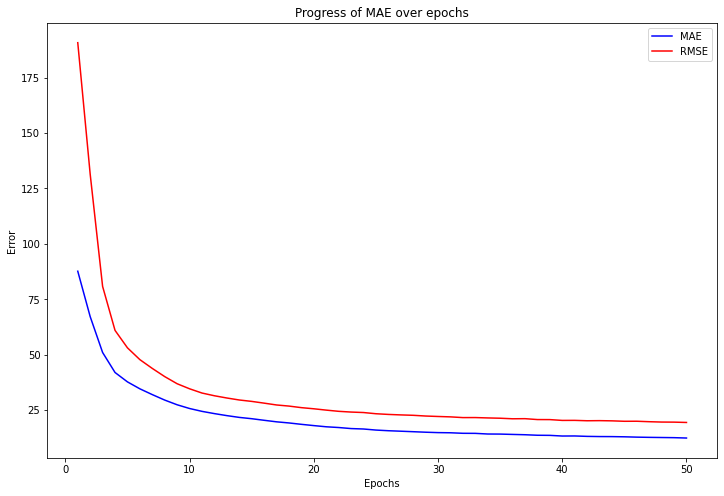

In [127]:
plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [128]:
pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("RMSE ", np.sqrt(mean_squared_error(y_train,pred)))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("RMSE ", np.sqrt(mean_squared_error(y_test,pred)))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  14.546280225666996
MSE  452.1664843806655
RMSE  21.264206648277888
R2  0.9895279427238477


ON TEST DATA:
MAE  14.643386766062767
MSE  483.2919179690319
RMSE  21.98390133641051
R2  0.9889219591851153


##### In comparison to the SVR this first NN returns much better results. Furthermore the NN isn't overfitted. 

In [129]:
# increase epochs 
model = build_model()
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=128,verbose=0)
pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  9.237134537202122
MSE  269.023540981134
R2  0.9937694852955621


ON TEST DATA:
MAE  9.143337590130407
MSE  261.7884566519518
R2  0.993999272282799


In [130]:
# use adam as optimizer
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=0)

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  10.083741926292406
MSE  265.6786394733399
R2  0.9938469523378632


ON TEST DATA:
MAE  10.151160969844847
MSE  265.23675847245283
R2  0.9939202301410018


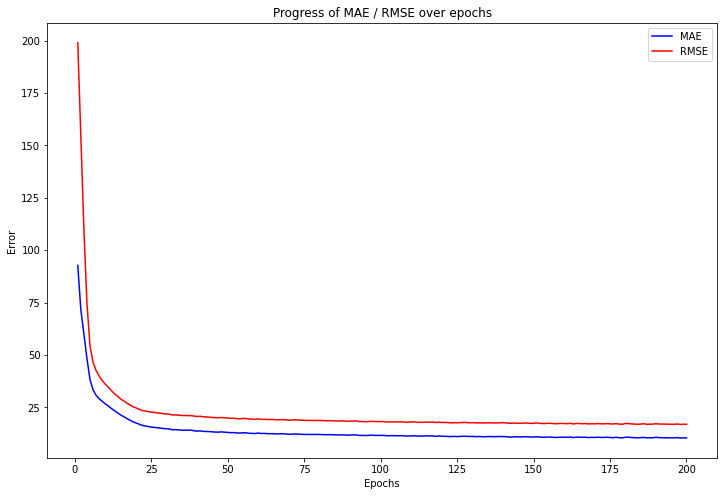

ON TRAINING DATA:
MAE  10.072372604693806
MSE  275.4019407149962
R2  0.993621763229353


ON TEST DATA:
MAE  10.485889544479623
MSE  294.13185547765994
R2  0.9932578953241505


In [132]:
# drop one hidden layer and see what happens
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

history = model.fit(scaler.fit_transform(X_train),y_train,epochs=200,batch_size=128,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

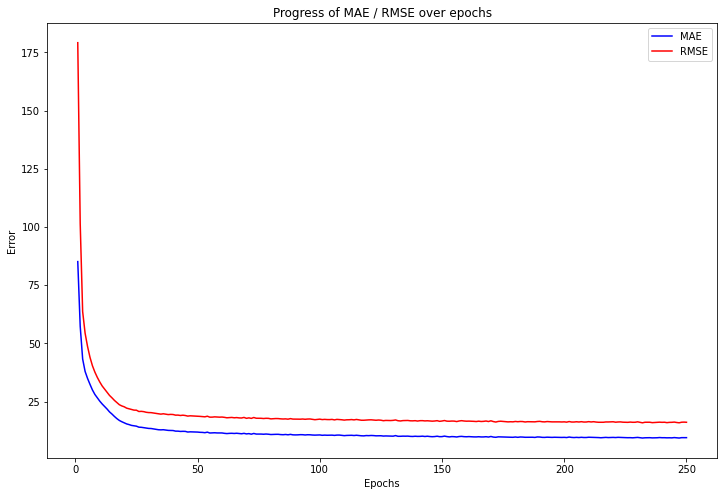

ON TRAINING DATA:
MAE  9.305175582440405
MSE  246.3836554064091
R2  0.994293819112096


ON TEST DATA:
MAE  9.92642969113538
MSE  281.39116190674935
R2  0.9935499381209381


In [131]:
# drop one hidden layer and see what happens
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

# increase number of epochs 
# decrease batch_size
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=250,batch_size=64,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

# Optimizing Hyperparameters with GridSearch

#### Epochs, Batch Size and Optimizer

###### previous results  with ... 
epochs: 50 <br>
batch size: 128 <br>
optimizer: Adam <br>

ON TRAINING DATA: <br>
MAE  10.083741926292406 <br>
MSE  265.6786394733399 <br>
R2  0.9938469523378632 <br>


ON TEST DATA: <br>
MAE  10.151160969844847 <br>
MSE  265.23675847245283 <br>
R2  0.9939202301410018 <br>

Although the results are already very good, we will see if the hyper parameters can be optimized with GridSearch even more.

In [139]:
# Function to build the model, required for KerasClassifier
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=build_model, verbose=0)

# search for best batch size and number of epochs 
# define the grid search parameters
batch_size = [32,64,128,256]
epochs = [20,50,100,100]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# run grid search 
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.001071 using {'batch_size': 32, 'epochs': 100}
0.000664 (0.000316) with: {'batch_size': 32, 'epochs': 20}
0.000621 (0.000109) with: {'batch_size': 32, 'epochs': 50}
0.001071 (0.000561) with: {'batch_size': 32, 'epochs': 100}
0.000471 (0.000030) with: {'batch_size': 32, 'epochs': 100}
0.000343 (0.000218) with: {'batch_size': 64, 'epochs': 20}
0.000771 (0.000157) with: {'batch_size': 64, 'epochs': 50}
0.000514 (0.000091) with: {'batch_size': 64, 'epochs': 100}
0.000407 (0.000212) with: {'batch_size': 64, 'epochs': 100}
0.000750 (0.000212) with: {'batch_size': 128, 'epochs': 20}
0.000600 (0.000121) with: {'batch_size': 128, 'epochs': 50}
0.000514 (0.000052) with: {'batch_size': 128, 'epochs': 100}
0.000728 (0.000237) with: {'batch_size': 128, 'epochs': 100}
0.000728 (0.000160) with: {'batch_size': 256, 'epochs': 20}
0.000536 (0.000289) with: {'batch_size': 256, 'epochs': 50}
0.000343 (0.000357) with: {'batch_size': 256, 'epochs': 100}
0.000578 (0.000344) with: {'batch_size': 256, 

Gridsearch has found the optimal batch size = 32 and the optimal number of epochs = 100.
On the basis of these two hyperparameters we are looking for the optimal optimizer using GridSearch.

In [134]:
# Function to create model, required for KerasClassifier
def build_model(optimizer="adam"):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae','accuracy'])
    return model

model = KerasClassifier(build_fn=build_model, epochs=100, batch_size=32, verbose=0)

# define the grid search parameters for optimizer 
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.000835 using {'optimizer': 'Adamax'}
0.000000 (0.000000) with: {'optimizer': 'SGD'}
0.000771 (0.000240) with: {'optimizer': 'RMSprop'}
0.000471 (0.000289) with: {'optimizer': 'Adagrad'}
0.000728 (0.000184) with: {'optimizer': 'Adadelta'}
0.000493 (0.000259) with: {'optimizer': 'Adam'}
0.000835 (0.000091) with: {'optimizer': 'Adamax'}
0.000686 (0.000316) with: {'optimizer': 'Nadam'}


GridSearch has found the optimal optimizer = 'Adamax'. In the following model we use the found hyper parameters.

In [138]:
scaler = StandardScaler()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adamax', loss='mse', metrics=['mae','mse']) #set the new optimizer 
    return model

model = build_model()

# use results of grid search for epochs and batch size 
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=32,verbose=0)

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TEST DATA:
MAE  9.304667240804566
MSE  253.8314977831905
R2  0.9941816620804206


**The resulting metrics are minimally improved due to the optimized hyper parameters. Since the performance of the NN model was already so good before, there was not much room for improvement.**

# Varying Hexagon resolution and periods

First of all, we create a function (prepareAvailabilityData) that does all the necessary steps for the preparation of the availability dataframe for different hexagon resolutions and time baskets. 

In [140]:
# read in transformed availability data
availability_data = pd.read_csv("Data/bonn_availability.csv", index_col=0)

In [141]:
from h3 import h3 
def createHexagons(df, resolution):    
    df["h3_hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["p_lat"], row["p_lng"], resolution) if (row['p_lat'] and row['p_lng']) else 0, axis=1)
    return df

In [142]:
# function which returns True for saturday and sunday; otherwise it returns False
def isWeekend(index_of_day): 
    if index_of_day > 4: 
        return 1 
    else: 
        return 0

In [143]:
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

In [144]:
def prepareAvailabilityData(hex_resolution, periodLength, df=availability_data): 
    """
    periodLength = 24h / 6h / 2h / 1h
    hex_resolution = 5 / 6 / 7 / 8 / 9 
    """
    #Creating hexagons      
    availability_data = createHexagons(df, hex_resolution)
    
    trips = ['start', 'end']
    availability_data_start_end = df[df.trip.isin(trips)]
    
    availability_data2=availability_data_start_end.sort_values(['b_number', 'datetime'])
    
    #After checking the amount of end and start trips, we see that there is no even amount of start and end trips 
    #so let's check sequences and eliminate those that do not form a pair
    #it eliminates those where the b_number is the same and the trip type is the same of two following rows
    #and those where the bike number is not the same but the trip type is the same 
    m1 = (availability_data2['b_number'] == availability_data2['b_number'].shift(-1))
    m2 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    m3 = (availability_data2['b_number'] != availability_data2['b_number'].shift(-1))
    m4 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    availability = availability_data2[~((m1&m2)|(m3&m4))]
    
    #sort dataframe so that we can locate the first occurrence of every bike
    df_firstocc = df.sort_values(['month', 'day', 'hour'])
    
    #first occurence of every bike in 2019
    first_occ_ofallbikes = df_firstocc.loc[df_firstocc.trip =='first'].groupby('b_number').head(1)
    
    frames = [availability, first_occ_ofallbikes]
    
    availability_data_start_end_firstocc= pd.concat(frames)
    
    availability_data_start_end_firstocc2 = availability_data_start_end_firstocc
    
    #Adding column available bikes
    #For arriving trips (trip == 'end') and the first occurrence of every bike (trip == 'first') 1 is written into the new column, because one bike is added in each case. 
    #For starting trips (trip == 'start') 0 is written into the new column, because there is one bike leaving in each case.
    availability_data_start_end_firstocc2['available_bikes']= availability_data_start_end_firstocc2.apply(lambda x: 1 if ((x.trip == 'end')|(x.trip == 'first')) else (-1), axis=1)
    
    #Summing up of the Available bike column with GroupBy to calculate the value of how many bikes come and go per hexagon, month, day and hour .
    grouped_2 = availability_data_start_end_firstocc2[['h3_hex_id','month', 'day', 'hour', 'available_bikes']].groupby(['h3_hex_id','month', 'day', 'hour'], as_index = False).sum()
    
    grouped_2 = grouped_2.sort_values(['month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    for group in grouped_2.groups:
    
        group = grouped_2.get_group(group)
        group = group.reset_index()
        
        # Cumulative summing of the available bikes column per hexagon to get the number of available bikes per hexagon
        group['available_bikes']= np.cumsum(group['available_bikes'])  
    
        all_groups.append(group)

    cumulativesum_df = pd.concat(all_groups)
    
    #saving the unique h3_hex_ids
    h3_hex_ids = cumulativesum_df['h3_hex_id'].unique()
    
    #create new dataframe with the same columns
    all_availability = pd.DataFrame(columns=["h3_hex_id", "datetime", "month","day","hour", "available_bikes"])
    
    #add the unique h3_hex_ids
    all_availability['h3_hex_id'] = h3_hex_ids
    
    #create a time range for the new dataframe starting from the 20/01/2019 as our provided data starts at that time
    datelist = pd.date_range('2019-01-20 00:00:00', '2019-12-31 23:59:00', freq='H').tolist()

    for i in range(0, len(h3_hex_ids)):
        all_availability['datetime'][i] = datelist
    
    s = all_availability.apply(lambda x: pd.Series(x['datetime']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'datetime'

    all_availability = all_availability.drop('datetime', axis=1).join(s)
    
    all_availability["datetime"] = pd.to_datetime(all_availability["datetime"])
    all_availability["day"] = all_availability["datetime"].apply(lambda x: x.day)
    all_availability["month"] = all_availability["datetime"].apply(lambda x: x.month)
    all_availability["hour"] = all_availability["datetime"].apply(lambda x: x.hour)
    
    #Merge the grouped original dataframe with the new dataframe
    availability_per_hex = pd.merge(cumulativesum_df, all_availability, left_on=['h3_hex_id', 'month', 'day', 'hour'], right_on=['h3_hex_id', 'month', 'day', 'hour'], how="outer")
    availability_per_hex = availability_per_hex.drop('available_bikes_y', axis=1)
    availability_per_hex = availability_per_hex.rename(columns= {'available_bikes_x': 'available_bikes'})
    
    availability_per_hex_groups = availability_per_hex.sort_values(['h3_hex_id','month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    #split by groups   
    for group in availability_per_hex_groups.groups:
        group = availability_per_hex_groups.get_group(group)
        group = group.reset_index()
               
        #save the dataframe for one hexagon in the list all groups  
        all_groups.append(group)

    availability_per_hex = pd.concat(all_groups)
    
    availability_per_hex = availability_per_hex.drop(['level_0', 'index'], axis=1)
    
    #Applying a forward fill per group to add the missing hourly available bikes per hexagon
    availability_per_hour = availability_per_hex.groupby(['h3_hex_id'], as_index=False).apply(lambda group: group.ffill())
    
    #Filling the remaining NaN values with 0
    availability_per_hour = availability_per_hour.fillna(0)
    
    # adding column weekday
    availability_per_hour["weekday"] = availability_per_hour["datetime"].dt.dayofweek
    
    # adding new boolean column "weekend"    
    availability_per_hour["weekend"] = availability_per_hour["weekday"].apply(lambda x: isWeekend(x))
    
    availability_per_hour["center"] = availability_per_hour["h3_hex_id"].apply(lambda x: centroid(x))
    availability_per_hour["center_x"] = availability_per_hour["center"].apply(lambda x: x[0])
    availability_per_hour["center_y"]  = availability_per_hour["center"].apply(lambda x: x[1])
    
    availability_per_hour['time_basket'] = availability_per_hour['hour'].apply(lambda x: x//periodLength+1)

    availability_per_hour = availability_per_hour.groupby(['h3_hex_id', 'center_x', 'center_y', 'month', 'day', 'weekday', 'weekend', 'time_basket' ], as_index=False).mean()
    availability_per_hour.drop('hour', axis=1, inplace=True)
    ### Adding the average of the temperature and the distance to the next station, precipitation y/n and the mode of the land use features of the hexgaon

    # grouped dataframe to calculate the mean of the temperatur and the distance to the next station per day and timebasket 
    availability_data['time_basket'] = availability_data['hour'].apply(lambda x: x//periodLength+1)
    availability_per_hour['time_basket'] = availability_data['hour'].apply(lambda x: x//periodLength+1)
    grouped_distance_station = pd.DataFrame(availability_data.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False
                                                                     ).mean())
    #grouped_distance_station.reset_index(inplace=True)
    grouped_distance_station = grouped_distance_station[['time_basket', 'h3_hex_id', 'month', 'day', "distance_next_station"]]

    # merge mean temperature with the demands 
    df_availability = availability_per_hour.merge(grouped_distance_station, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # final dataframe to predict the demand per hexagon, ... 
    # adding new boolean column "weekend"    
    df_availability["weekend"] = df_availability["weekend"].apply(lambda x : 1 if x else 0)     

    # create new feature for better prediction results 
    # distances from the center of the hexagons to the CentralStation / University 
    df_availability["distanceToCentralStation"] = df_availability[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
    df_availability["distanceToUniversity"] = df_availability[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)    
    df_availability=df_availability.drop_duplicates()
    
    return df_availability
    

Now we define a function that runs a DL model with the hyperparameters optimized with GridSearch. In this function we can insert the availability dataframe of the different hexagon resolutions and time baskets.

In [148]:
def run_DL(df_availability):
    
    # feature selection 
    features = ["time_basket", "month", "center_x", "center_y", "weekend", 
            "distance_next_station", "distanceToCentralStation", "distanceToUniversity"]
    X = df_availability[features]
    y = df_availability[["available_bikes"]]
    X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
    
    #build model
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adamax', loss='mse', metrics=['mae','mse'])

    history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=32,verbose=0)

    pred = model.predict(scaler.fit_transform(X_train))
    print("ON TRAINING DATA:")
    print("MAE ", mean_absolute_error(y_train,pred))
    print("MSE ", mean_squared_error(y_train,pred))
    print("R2 ", r2_score(y_train,pred))
    print("\n")

    pred = model.predict(scaler.fit_transform(X_test))
    print("ON TEST DATA:")
    print("MAE ",mean_absolute_error(y_test,pred))
    print("MSE ",mean_squared_error(y_test,pred))
    print("R2 ",r2_score(y_test,pred))

## Deep Learning with ... 
* Hexagon resolution = 5 

In [150]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=1,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  16.448581033574342
MSE  694.8325988247565
R2  0.9775518773460116


ON TEST DATA:
MAE  16.704563542459113
MSE  738.969132237999
R2  0.9758371309084337


In [151]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=2,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  15.625065810421741
MSE  555.1712549038152
R2  0.982606002781066


ON TEST DATA:
MAE  15.885774245935963
MSE  583.0032312327445
R2  0.981196838982835


In [152]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=6,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  15.877622123787033
MSE  516.4233194640107
R2  0.9843246403771488


ON TEST DATA:
MAE  15.552763068935636
MSE  494.27298520963035
R2  0.9849337295942778


In [153]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=24,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  13.956894840611469
MSE  431.27471728719087
R2  0.9872020506875697


ON TEST DATA:
MAE  18.353499194989702
MSE  729.5665277671072
R2  0.977699231705413


## Deep Learning with... 
* Hexagon resolution = 6 

In [154]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=1,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  13.113438696816145
MSE  389.7108569335161
R2  0.9923144387980077


ON TEST DATA:
MAE  13.119940585268228
MSE  384.7504370169137
R2  0.9924626526630462


In [155]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=2,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  12.584722835300447
MSE  333.75927165821
R2  0.993098847891258


ON TEST DATA:
MAE  13.21781419372264
MSE  370.5784730062531
R2  0.9924066111089139


In [156]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=6,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  12.33853265143074
MSE  324.8466433441076
R2  0.9928701624306536


ON TEST DATA:
MAE  12.713922949642672
MSE  318.01084735868227
R2  0.9932763777221795


In [157]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=24,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  12.406719278922116
MSE  309.6926460560043
R2  0.9930398076010356


ON TEST DATA:
MAE  15.373348760025099
MSE  484.5322581441556
R2  0.989869345270887


## Deep Learning with... 
* Hexagon resolution = 7

In [158]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=1,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  10.053689430279828
MSE  300.2023251791075
R2  0.9947715712024839


ON TEST DATA:
MAE  10.244061821349545
MSE  302.16190542206675
R2  0.9944665923062423


In [159]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=2,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  9.903244136659191
MSE  304.6818775882543
R2  0.9938618795493488


ON TEST DATA:
MAE  10.049832534756812
MSE  304.56842191547895
R2  0.9938221377563022


In [160]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=6,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  9.378736460612805
MSE  243.0810761381734
R2  0.9943936659742756


ON TEST DATA:
MAE  9.647969585894351
MSE  254.20740439997425
R2  0.9935234058677173


In [161]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=24,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  10.365675823316845
MSE  268.4077616723604
R2  0.992921762503326


ON TEST DATA:
MAE  12.185580998837366
MSE  366.6520992042919
R2  0.9907430035925399


## Deep Learning with...
* Hexagon resolution = 8

In [162]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=1,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  5.661291497079582
MSE  72.91612229768018
R2  0.9911915116292056


ON TEST DATA:
MAE  5.714313531639755
MSE  74.48793976428699
R2  0.9912195521170108


In [163]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=2,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  5.449645548107764
MSE  69.40888581297844
R2  0.9900417073574928


ON TEST DATA:
MAE  5.674071716614941
MSE  76.50813759957718
R2  0.9892551680053248


In [164]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=6,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  6.2426600374896335
MSE  153.16923830931327
R2  0.9722780935868385


ON TEST DATA:
MAE  6.632141007548716
MSE  161.30923464800665
R2  0.970041704542337


In [165]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=24,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  7.425437387239179
MSE  112.78376180111628
R2  0.9757291171818415


ON TEST DATA:
MAE  8.140957925680713
MSE  143.16188845722067
R2  0.9702529914803226


## Deep Learning with...
* Hexagon resolution = 9

In [166]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=1,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  4.67530522631179
MSE  45.02233281816738
R2  0.9897846934838967


ON TEST DATA:
MAE  4.855072856108461
MSE  49.1829324201638
R2  0.9891634072463258


In [167]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=2,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  5.21207847445257
MSE  62.90534625238511
R2  0.9867934012433354


ON TEST DATA:
MAE  5.307520446323912
MSE  65.16813861841594
R2  0.986146455404365


In [168]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=6,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  6.3088960696185685
MSE  95.68157351813078
R2  0.9583044899642704


ON TEST DATA:
MAE  6.371373369556632
MSE  96.59535226681051
R2  0.9562065246758563


In [169]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=24,df=availability_data)

run_DL(df_availability)

ON TRAINING DATA:
MAE  8.235511921520958
MSE  172.4697835845578
R2  0.8956475307253755


ON TEST DATA:
MAE  8.374313106774068
MSE  184.91752337190402
R2  0.8818920868922782
